1. Importa las librerías necesarias y la base de datos, y realiza un análisis por variable usando visualizaciones. Debes considerar las posibles correlaciones y representarlas
   en un heatmap.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import f1_score, mean_squared_error, r2_score, classification_report, accuracy_score


import warnings
warnings.filterwarnings('ignore')


RSTATE= 109705
df = pd.read_csv("telecom_churn.csv")

In [2]:
print(f'{df.info()}\n')
print(f'{df.head(10)}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB
None

   Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1       2.70              1   
1      0           107                1         1       3.70              1   


<Axes: >

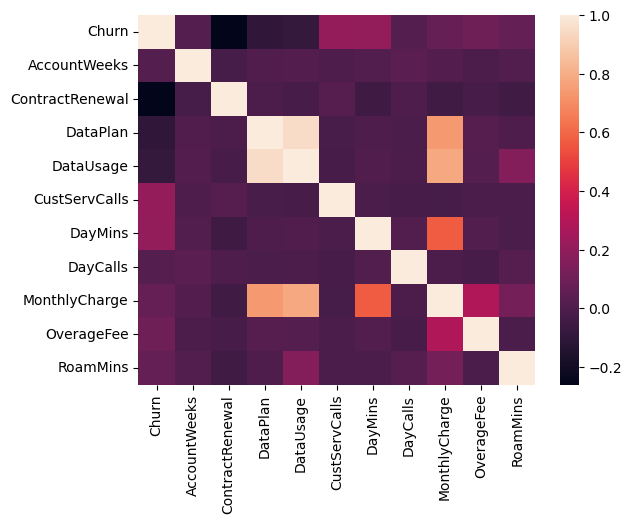

In [3]:
sns.heatmap(df.corr())

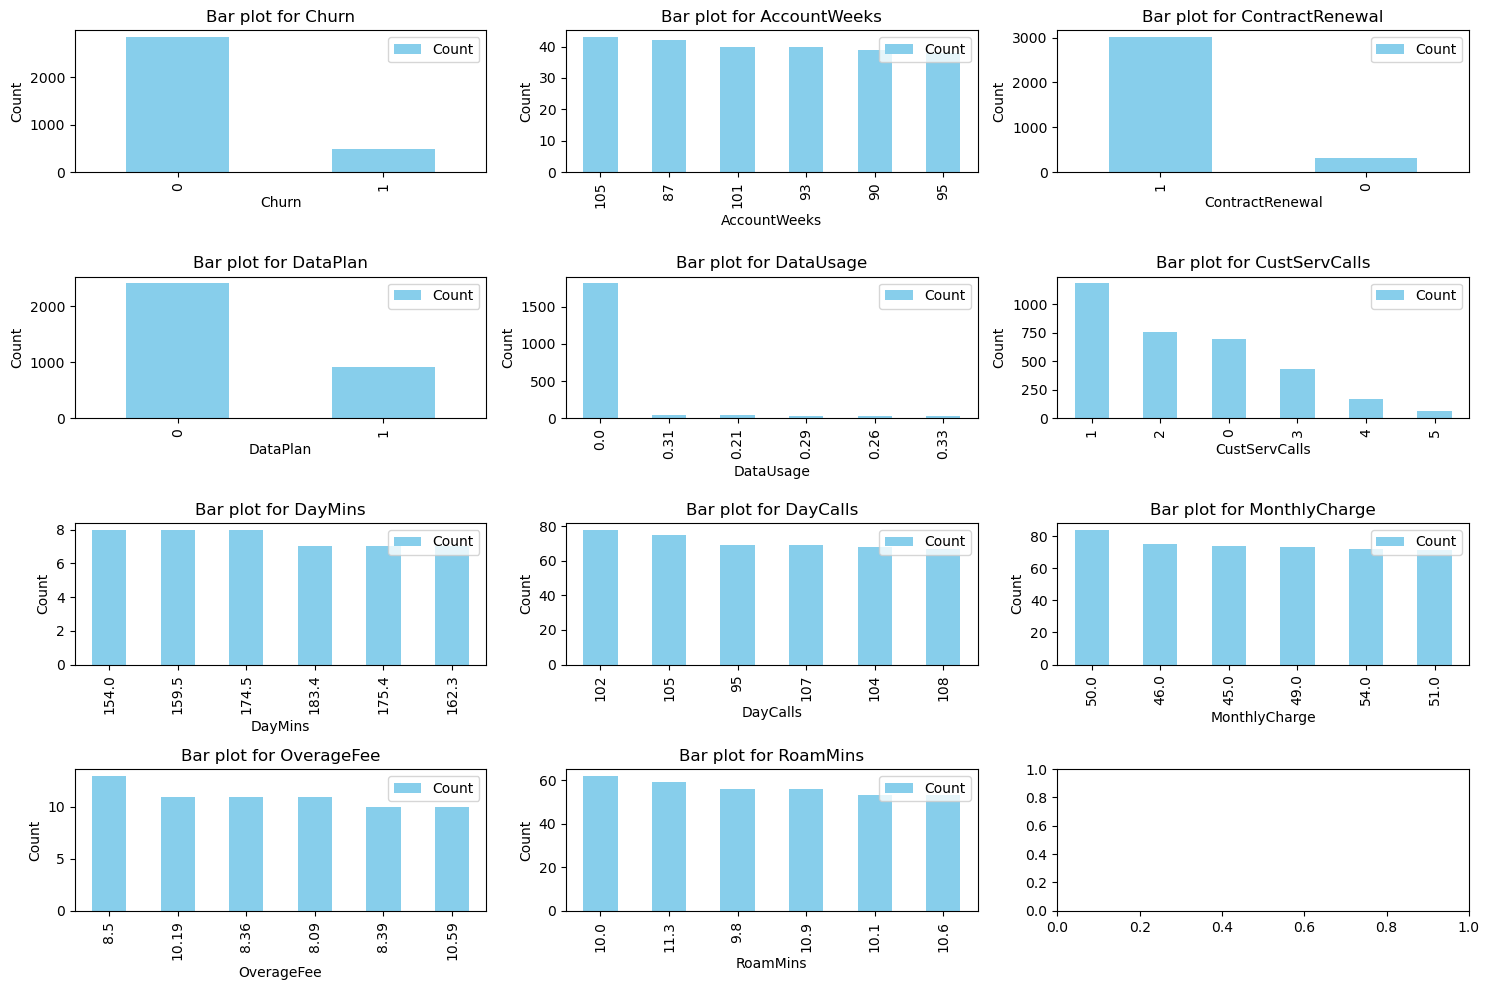

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize= (15, 10))
for i, column in enumerate(df.columns):
    row, col = divmod(i,3)
    ax = axes[row, col]
    grouped_data = df[column].value_counts().reset_index()
    grouped_data.columns = [column, 'Count']
    top_categories = grouped_data.head(6)
    top_categories.plot(kind='bar', x=column, y='Count', color='skyblue',ax=ax)
    ax.set_title(f'Bar plot for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

2. Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando    búsqueda por grilla con 5 kfold:
        max_depth: [5, 10, 15, 20, 25]
        min_samples_split: [0.01, 0.02, 0.03, 0.04]
Da a conocer los mejores hiper parámetros encontrados y el desempeño del modelo, tanto en los datos de entrenamiento como en los de test.

In [5]:
df1 = df
X = df1.drop(columns=['Churn'], axis=1)
y= df1['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=RSTATE)

In [6]:
#Para este caso utilizaremos un Tree Classifier de sklearn
first_model = DecisionTreeClassifier(random_state=RSTATE)
first_model.fit(X_train, y_train)
yhat_pred= first_model.predict(X_test)
print(classification_report(y_test, yhat_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       925
           1       0.65      0.61      0.63       175

    accuracy                           0.88      1100
   macro avg       0.79      0.77      0.78      1100
weighted avg       0.88      0.88      0.88      1100



In [7]:
#Mejora del modelo con busqueda por grilla de 5kfold:
param_grid = {
    'max_depth':[5,10,15,20,25],
    'min_samples_split':[0.01, 0.02, 0.03, 0.04]
}
p_first_model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=p_first_model, param_grid=param_grid, cv=5)
grid_search.fit(X,y)
yhat_pred2 = grid_search.predict(X_test)
best_params= grid_search.best_params_
print(f'Best Parameters: {best_params}')
print(classification_report(y_test, yhat_pred2))

Best Parameters: {'max_depth': 10, 'min_samples_split': 0.01}
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       925
           1       0.93      0.66      0.77       175

    accuracy                           0.94      1100
   macro avg       0.93      0.83      0.87      1100
weighted avg       0.94      0.94      0.93      1100



3. Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

In [8]:
#Importar e instanciar SMOTE balancear las clases y utilizar Baggings
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RSTATE)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.ravel())

print('OverSampling of the shape of train_X: {}'.format(X_train_sm.shape))
print('OverSampling of the shape of train_y: {}'.format(y_train_sm.shape))

OverSampling of the shape of train_X: (3850, 10)
OverSampling of the shape of train_y: (3850,)


In [9]:
bg1 = BaggingClassifier(n_estimators=200, random_state=RSTATE, n_jobs=-1)
bg1.fit(X_train_sm, y_train_sm.ravel())
y_bgtest= bg1.predict(X_test)
print(classification_report(y_test, y_bgtest))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       925
           1       0.67      0.73      0.70       175

    accuracy                           0.90      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.90      0.90      0.90      1100



4. Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap (T).
Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más
importante en la lista de modelos a entrenar. Considera que un mejor modelo es
aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto
de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el
archivo util_bagging.py)


In [10]:
#Creating the bootstrap sample
df_bootstrap_sample = df1.sample(n = 200, replace=True)
df_bootstrap_sample

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
604,0,30,1,0,0.00,1,169.9,144,49.0,11.26,11.4
582,0,104,1,0,0.00,1,164.2,109,42.0,7.77,10.7
129,0,131,1,1,2.57,3,214.2,115,76.7,8.09,9.5
988,0,138,1,0,0.28,3,171.4,117,41.8,5.76,17.0
1988,0,59,1,0,0.42,1,150.2,70,46.2,9.29,12.1
...,...,...,...,...,...,...,...,...,...,...,...
1013,0,104,1,0,0.00,1,156.2,93,43.0,9.65,13.1
344,0,64,1,1,3.59,1,154.6,92,69.9,4.17,13.3
2610,0,69,1,1,1.59,1,155.0,98,54.9,7.12,5.9
1087,0,109,1,0,0.00,1,217.0,115,55.0,10.35,8.2


In [11]:
X = df_bootstrap_sample.drop(columns=['Churn'], axis=1)
y = df_bootstrap_sample['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=RSTATE)

In [25]:
estimators1 = [
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    SVC(kernel='sigmoid', C=2.3),
    LogisticRegression(max_iter=10000)
]

for estimator in estimators1:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    accuarcy = accuracy_score(y_test, y_pred)
    print(f'{estimator.__class__.__name__} Accuarcy: {accuarcy}')
    print(classification_report(y_test, y_pred))

DecisionTreeClassifier Accuarcy: 0.889090909090909
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       925
           1       0.66      0.63      0.65       175

    accuracy                           0.89      1100
   macro avg       0.79      0.79      0.79      1100
weighted avg       0.89      0.89      0.89      1100

SVC Accuarcy: 0.8409090909090909
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       925
           1       0.00      0.00      0.00       175

    accuracy                           0.84      1100
   macro avg       0.42      0.50      0.46      1100
weighted avg       0.71      0.84      0.77      1100

SVC Accuarcy: 0.74
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       925
           1       0.12      0.10      0.11       175

    accuracy                           0.74      1100
   macro avg       0.48  

In [18]:
from util_bagging import bagging_het

df2 = df1
X = df2.drop(columns=['Churn'], axis=1)
y = df2['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=RSTATE)

estimators2=[
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    SVC(kernel='sigmoid', C=2.3),
    LogisticRegression(max_iter=10000)
]
lst_estimators1, result1, yhat, idx_oob = bagging_het(X_train, y_train, 200, estimators2, X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       925
           1       1.00      0.02      0.03       175

    accuracy                           0.84      1100
   macro avg       0.92      0.51      0.47      1100
weighted avg       0.87      0.84      0.77      1100



5. Implementa un modelo de ensamble Random Forest usando como hiper parámetro n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

X_train: (2233, 10)
X_test: (1100, 10)


In [37]:
#Instancia de modelo, split para datos de prueba y entrenamiento
df3 = df
X = df3.drop(columns=['Churn'], axis=1)
y = df3['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33,random_state=RSTATE)
RFC = RandomForestClassifier(max_features='sqrt', n_estimators=45, random_state=RSTATE, oob_score=True, n_jobs=-1)
#ENtrenar el modelo
RFC.fit(X_train, y_train)
#prediccion para el conjunto de Train
yhat_predict = RFC.predict(X_train)
#Prediccion para el conjunto de test
y_predRFC = RFC.predict(X_test)
#Mostrando el Accuarcy del modelo para cada conjunto
print(f'Accuarcy Test group: {accuracy_score(y_test, y_predRFC)}')
#Mostrando el Accuarcy del modelo para cada conjunto
print(f'Accuarcy Train group: {accuracy_score(y_train, yhat_predict)}')
#Mostrar el reporte de clasificacion
print(f'\n Classification Report:{classification_report(y_test, y_predRFC)}')
#POdemos comparar los f1-score con los otros modelos y para el conjunto test es uno de los más altos
#Para el DF entero el ajuste del modelo es correcto y uno de los mejores

Accuarcy Test group: 0.9236363636363636
Accuarcy Train group: 0.9982086878638603

 Classification Report:              precision    recall  f1-score   support

           0       0.93      0.98      0.96       925
           1       0.86      0.62      0.72       175

    accuracy                           0.92      1100
   macro avg       0.90      0.80      0.84      1100
weighted avg       0.92      0.92      0.92      1100



In [38]:
RFC.oob_score_

0.9373040752351097

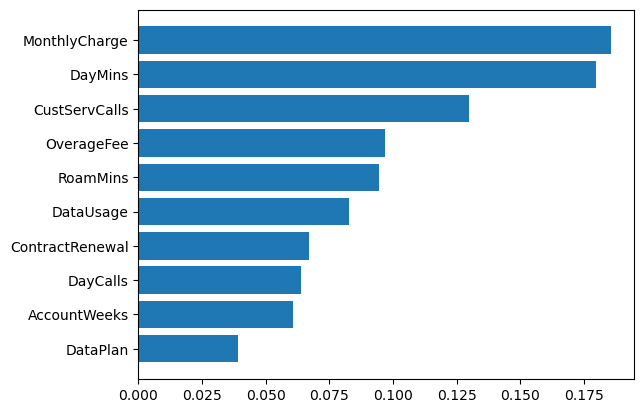

In [40]:
#Podemor ver que las cuartro principales carácteristicas más importantes son la facturación mensual, la cantidad de minutos por día, los llamdos a servicio al cliente
#Y la cuota más alta de exceso de los ultimos 12 meses
idx_sort= np.argsort(RFC.feature_importances_)
plt.barh(y=RFC.feature_names_in_[idx_sort], width=RFC.feature_importances_[idx_sort]);

6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:
                        n_estimators: 50 - 200 con paso de 10 completando 15 valores
                        max_features: [‘sqrt’, ‘log2’, None]
Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en los datos OOB, y despliega los cuatro atributos más importantes. 
¿Tienen sentido estos? Analiza además las métricas de desempeño, ROC y AUC.


In [45]:
%%time
#Partiremos definiendo nuestra grilla de parametros como lo solicitados
param_grid2={ 
    'n_estimators': (50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200),
    'max_features': ['sqrt', 'log2', None]
}

#Instanciamos GridSearch y le entregamos como paraemtro el RFR con OOB y random_state, dentro de este llamamos a la grilla de parametros creada antes, con 5 validaciones cruzadas
grid_rfc = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=RSTATE),
    param_grid= param_grid2,
    n_jobs=-1,
    cv=5
)

grid_rfc.fit(X_train, y_train)

CPU times: total: 703 ms
Wall time: 1min 2s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=109705),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': (50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200)})

In [46]:
print("Los mejores hiperparametros encontrados: ")
print(grid_rfc.best_params_)

Los mejores hiperparametros encontrados: 
{'max_features': 'sqrt', 'n_estimators': 130}


In [48]:
#En base a los hiperparametros encontrados entrenaremos un modelo con RFC
RFC2 = RandomForestClassifier(max_features='sqrt', n_estimators=130, random_state=RSTATE, oob_score=True, n_jobs=-1)
RFC2.fit(X_train, y_train)
y_train_pred = RFC2.predict(X_train)
y_test_pred = RFC2.predict(X_test)
print(f'accuarcy for Train Group: {accuracy_score(y_train, y_train_pred)}')
print(f'accuarcy for Test Group: {accuracy_score(y_test, y_test_pred)}')
print(f'Classification Report for Test group: {classification_report(y_test, y_test_pred)}')

accuarcy for Train Group: 1.0
accuarcy for Test Group: 0.9236363636363636
Classification Report for Test group:               precision    recall  f1-score   support

           0       0.93      0.98      0.96       925
           1       0.87      0.61      0.72       175

    accuracy                           0.92      1100
   macro avg       0.90      0.80      0.84      1100
weighted avg       0.92      0.92      0.92      1100



In [53]:
from sklearn import metrics
print(f'The ROC AUC is: {metrics.roc_auc_score(y_train, y_train_pred)}')
#El modelo puede separar perfectametne las clases positivas de las negativas sin cometer errores.

The ROC AUC is: 1.0


In [49]:
RFC2.oob_score_

0.9399910434393193

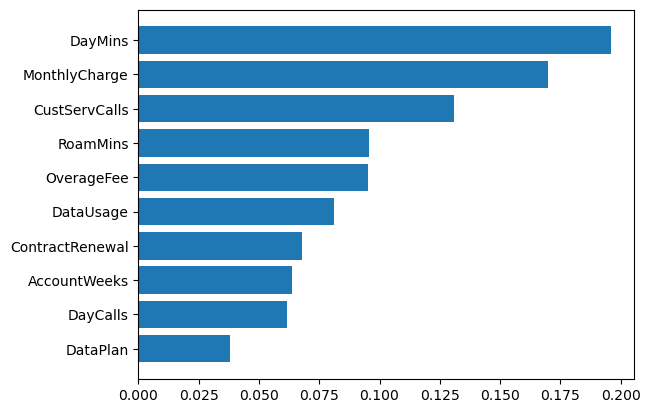

In [50]:
#Con este ajuste podemos observar el cambio en las 4 primeras features, pasando DayMins al primer lugar; luego cargos mensuales, llamadas a servicio al cliente y minutos de roaming
idx_sort2= np.argsort(RFC2.feature_importances_)
plt.barh(y=RFC2.feature_names_in_[idx_sort2], width=RFC2.feature_importances_[idx_sort2]);

7. Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a renunciar.


In [54]:
#APlicamos el modelo a X para todo el df
customer_predict = RFC2.predict_proba(X)[:,1]
customer_predict

array([0.03846154, 0.00769231, 0.        , ..., 0.06153846, 0.38461538,
       0.01538462])

In [55]:
df4 = df.copy()

In [56]:
#Creamos la column prediccion de cliente con el resultado del modelo
df4['Customer_pred']= customer_predict
df4

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Customer_pred
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0,0.038462
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7,0.007692
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2,0.000000
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6,0.169231
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1,0.053846
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9,0.030769
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6,0.069231
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1,0.061538
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0,0.384615


In [61]:
# df4[df4['Churn']==1]
#Sortear el DF por la columna creada mostrando los primeros 15 registros que nos muestran los clientes que podrían cancelar el servicio
df4.sort_values(by=['Customer_pred'], ascending=False).head(15)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Customer_pred
1345,1,98,1,0,0.0,4,0.0,0,14.0,7.98,6.8,1.000000
859,1,93,1,0,0.0,3,267.9,114,65.0,11.15,11.3,1.000000
2647,1,116,1,0,0.0,0,288.0,120,71.0,12.79,13.4,1.000000
2696,1,74,1,0,0.0,3,314.1,86,73.0,11.12,12.3,1.000000
914,1,179,1,0,0.0,0,287.3,123,74.0,14.40,10.5,1.000000
2267,1,29,1,0,0.0,2,313.2,103,72.0,10.82,12.8,1.000000
3072,1,75,1,0,0.0,0,305.1,106,68.0,9.40,8.5,0.992308
901,1,23,1,0,0.0,2,321.6,107,77.0,12.58,11.3,0.992308
3272,1,133,1,0,0.0,2,295.0,141,70.0,11.18,12.9,0.992308
1078,1,80,1,0,0.0,0,322.3,113,74.0,11.10,6.7,0.992308
